In [ ]:
import math

# 定数
g0 = 9.81  # m/s²
delta_v_required = 9400  # m/s

# 液体ロケット燃料の組み合わせ（真空Isp）
fuel_combo = [
    {"fuel": "RP-1/LOX", "isp_vac": 350},
    {"fuel": "LH2/LOX", "isp_vac": 450},
    {"fuel": "Methane/LOX", "isp_vac": 370},
]

# 貨物質量（kg）
cargo_list = [500, 1000, 2000]

# サブシステム＋構造＋エンジンの質量（kg）
subsystem_mass = 2000

# 結果保存
result_isp = [[0 for _ in range(len(fuel_combo))] for _ in range(len(cargo_list))]
result_fuel = [[0 for _ in range(len(fuel_combo))] for _ in range(len(cargo_list))]

def isp_calculation(fuel_cfg):
    return fuel_cfg["isp_vac"]

def fuel_calculation(cargo_mass, isp):
    mf = cargo_mass + subsystem_mass
    ve = isp * g0
    try:
        mass_ratio = math.exp(delta_v_required / ve)
        m0 = mf * mass_ratio
        propellant_mass = m0 - mf
    except OverflowError:
        propellant_mass = float('inf')
    return propellant_mass

# 計算実行
for i in range(len(cargo_list)):
    for j in range(len(fuel_combo)):
        isp = isp_calculation(fuel_combo[j])
        result_isp[i][j] = isp
        result_fuel[i][j] = fuel_calculation(cargo_list[i], isp)

# 結果表示
for i in range(len(cargo_list)):
    print(f"Cargo: {cargo_list[i]} kg")
    for j in range(len(fuel_combo)):
        print(f"  Fuel: {fuel_combo[j]['fuel']}")
        print(f"    Isp: {result_isp[i][j]} s")
        print(f"    Fuel Required: {result_fuel[i][j]:.2f} kg")


Cargo: 500 kg
  Fuel: RP-1/LOX
    Isp: 350 s
    Fuel Required: 36129.72 kg
  Fuel: LH2/LOX
    Isp: 450 s
    Fuel Required: 18523.42 kg
  Fuel: Methane/LOX
    Isp: 370 s
    Fuel Required: 30815.96 kg
Cargo: 1000 kg
  Fuel: RP-1/LOX
    Isp: 350 s
    Fuel Required: 43355.66 kg
  Fuel: LH2/LOX
    Isp: 450 s
    Fuel Required: 22228.11 kg
  Fuel: Methane/LOX
    Isp: 370 s
    Fuel Required: 36979.15 kg
Cargo: 2000 kg
  Fuel: RP-1/LOX
    Isp: 350 s
    Fuel Required: 57807.55 kg
  Fuel: LH2/LOX
    Isp: 450 s
    Fuel Required: 29637.48 kg
  Fuel: Methane/LOX
    Isp: 370 s
    Fuel Required: 49305.53 kg


Change isp to linear change ← further changes needed

Change to recursive formula

↓↓↓βver.↓↓↓

In [ ]:
# γver.
import math

# 定数
g0 = 9.81
delta_v_required = 9400  # m/s
max_altitude = 200000  # m (最終到達点)
average_altitude = max_altitude / 2  # 平均高度として仮定

# 燃料データ（地上・真空のISP）
fuel_combo = [
    {"fuel": "RP-1/LOX", "isp_sea": 280, "isp_vac": 350},
    {"fuel": "LH2/LOX", "isp_sea": 370, "isp_vac": 450},
    {"fuel": "Methane/LOX", "isp_sea": 320, "isp_vac": 380},
]

# 搭載貨物（kg）
cargo_list = [500, 1000, 2000]

# 結果格納用
result_isp = [[0 for _ in fuel_combo] for _ in cargo_list]
result_fuel = [[0 for _ in fuel_combo] for _ in cargo_list]
result_subsystem = [[0 for _ in fuel_combo] for _ in cargo_list]

# 平均ISPを高度に基づいて線形補完
def average_isp(fuel_cfg, avg_alt=average_altitude):
    ratio = avg_alt / max_altitude
    return fuel_cfg["isp_sea"] + (fuel_cfg["isp_vac"] - fuel_cfg["isp_sea"]) * ratio

# 燃料・サブシステム計算
def fuel_calculation(cargo_mass, fuel_cfg):
    isp = average_isp(fuel_cfg)
    ve = isp * g0
    tolerance = 0.01
    fuel_mass = 1000  # 初期仮定
    iteration = 0
    max_iter = 100

    while True:
        subsystem_mass = 0.01 * fuel_mass + 20  # サブシステム質量（動的）
        mf = cargo_mass + subsystem_mass  # 乾燥質量（cargo + subsystem）

        try:
            mass_ratio = math.exp(delta_v_required / ve)
            m0 = mf * mass_ratio  # 湿潤質量
            fuel_mass_new = m0 - mf
        except OverflowError:
            return float('inf'), isp, float('inf')

        if abs(fuel_mass_new - fuel_mass) < tolerance or iteration > max_iter:
            break

        fuel_mass = fuel_mass_new
        iteration += 1

    subsystem_mass = 0.01 * fuel_mass + 20  # 最終的なサブシステム質量
    return fuel_mass, isp, subsystem_mass

# 計算ループ
for i in range(len(cargo_list)):
    for j in range(len(fuel_combo)):
        fuel_mass, isp, subsystem_mass = fuel_calculation(cargo_list[i], fuel_combo[j])
        result_isp[i][j] = isp
        result_fuel[i][j] = fuel_mass
        result_subsystem[i][j] = subsystem_mass

# 結果出力
for i, cargo in enumerate(cargo_list):
    print(f"\nCargo: {cargo} kg")
    for j, fuel in enumerate(fuel_combo):
        isp = result_isp[i][j]
        fuel_mass = result_fuel[i][j]
        subsystem_mass = result_subsystem[i][j]
        dry_mass = cargo + subsystem_mass
        wet_mass = dry_mass + fuel_mass
        dry_wet_ratio = dry_mass / wet_mass * 100

        print(f"  Fuel: {fuel['fuel']}")
        print(f"    Avg Isp: {isp:.2f} s")
        print(f"    Required Fuel: {fuel_mass:.2f} kg")
        print(f"    Final Subsystem Mass: {subsystem_mass:.2f} kg")
        print(f"    Dry Mass: {dry_mass:.2f} kg")
        print(f"    Wet Mass: {wet_mass:.2f} kg")
        print(f"    Dry/Wet Ratio: {dry_wet_ratio:.2f}%")



Cargo: 500 kg
  Fuel: RP-1/LOX
    Avg Isp: 315.00 s
    Required Fuel: 12955.74 kg
    Final Subsystem Mass: 149.56 kg
    Dry Mass: 649.56 kg
    Wet Mass: 13605.30 kg
    Dry/Wet Ratio: 4.77%
  Fuel: LH2/LOX
    Avg Isp: 410.00 s
    Required Fuel: 5364.15 kg
    Final Subsystem Mass: 73.64 kg
    Dry Mass: 573.64 kg
    Wet Mass: 5937.79 kg
    Dry/Wet Ratio: 9.66%
  Fuel: Methane/LOX
    Avg Isp: 350.00 s
    Required Fuel: 8784.50 kg
    Final Subsystem Mass: 107.84 kg
    Dry Mass: 607.84 kg
    Wet Mass: 9392.34 kg
    Dry/Wet Ratio: 6.47%

Cargo: 1000 kg
  Fuel: RP-1/LOX
    Avg Isp: 315.00 s
    Required Fuel: 25413.18 kg
    Final Subsystem Mass: 274.13 kg
    Dry Mass: 1274.13 kg
    Wet Mass: 26687.31 kg
    Dry/Wet Ratio: 4.77%
  Fuel: LH2/LOX
    Avg Isp: 410.00 s
    Required Fuel: 10521.98 kg
    Final Subsystem Mass: 125.22 kg
    Dry Mass: 1125.22 kg
    Wet Mass: 11647.20 kg
    Dry/Wet Ratio: 9.66%
  Fuel: Methane/LOX
    Avg Isp: 350.00 s
    Required Fuel: 17231

In [ ]:
# δver.

import math

# Constants
g0 = 9.81  # m/s²
delta_v_total = 9400  # m/s total
delta_v_sea = 2000     # atmospheric phase
delta_v_vac = delta_v_total - delta_v_sea

# Max altitude for interpolation (used by hybrid only)
max_altitude = 200000
average_altitude = max_altitude / 2

# Fuels
# Fuels ─ add the new line at the end ↓
fuel_combo = [
    {"fuel": "RP-1/LOX",               "isp_sea": 280,  "isp_vac": 350},
    {"fuel": "LH2/LOX",                "isp_sea": 370,  "isp_vac": 450},
    {"fuel": "Methane/LOX",            "isp_sea": 320,  "isp_vac": 380},
    {"fuel": "Hybrid RP1+LH2",         "isp_sea": (280 + 370) / 2,
                                        "isp_vac": (350 + 450) / 2},
    {"fuel": "Air‑Breather + RP‑1/LOX","isp_sea": 1800, "isp_vac": 350,
                                        "airbreathing": True},
    {"fuel": "Air‑Breather + LH2/LOX", "isp_sea": 2200, # ← new entry
                                        "isp_vac": 450,
                                        "airbreathing": True}
]

cargo_list = [500, 1000, 2000]

def solve_rocket(delta_v, isp, mf):
    ve = isp * g0
    try:
        mass_ratio = math.exp(delta_v / ve)
        m0 = mf * mass_ratio
        fuel_mass = m0 - mf
        return fuel_mass, m0
    except OverflowError:
        return float('inf'), float('inf')

def fuel_calculation(cargo_mass, fuel_cfg):
    use_airbreather = fuel_cfg.get("airbreathing", False)
    isp_sea = fuel_cfg["isp_sea"]
    isp_vac = fuel_cfg["isp_vac"]

    # Initial guesses
    subsystem_mass = 0
    tolerance = 0.01
    fuel_mass = 1000
    iteration = 0
    max_iter = 100

    while True:
        subsystem_mass = 0.01 * fuel_mass + 20
        dry_mass = cargo_mass + subsystem_mass

        if use_airbreather:
            # Assume air-breather handles sea-level Δv without onboard oxidizer
            fuel_sea, m1 = solve_rocket(delta_v_sea, isp_sea, dry_mass)
            fuel_vac, m0 = solve_rocket(delta_v_vac, isp_vac, m1)
            total_fuel = fuel_sea + fuel_vac
        else:
            # Two-phase traditional rocket
            fuel_vac, m1 = solve_rocket(delta_v_vac, isp_vac, dry_mass)
            fuel_sea, m0 = solve_rocket(delta_v_sea, isp_sea, m1)
            total_fuel = fuel_sea + fuel_vac

        if abs(total_fuel - fuel_mass) < tolerance or iteration > max_iter:
            break
        fuel_mass = total_fuel
        iteration += 1

    dry_to_wet = dry_mass / m0 * 100
    fuel_mass_fraction = total_fuel / m0 * 100
    return {
        "fuel_mass": total_fuel,
        "subsystem_mass": subsystem_mass,
        "wet_mass": m0,
        "dry_mass": dry_mass,
        "dry_wet_ratio": dry_to_wet,
        "fuel_fraction": fuel_mass_fraction
    }

# Run simulations
for cargo in cargo_list:
    print(f"\n=== Cargo: {cargo} kg ===")
    for fuel in fuel_combo:
        result = fuel_calculation(cargo, fuel)
        print(f"  Fuel: {fuel['fuel']}")
        print(f"    Fuel Mass: {result['fuel_mass']:.2f} kg")
        print(f"    Subsystem Mass: {result['subsystem_mass']:.2f} kg")
        print(f"    Dry Mass: {result['dry_mass']:.2f} kg")
        print(f"    Wet Mass: {result['wet_mass']:.2f} kg")
        print(f"    Dry/Wet Ratio: {result['dry_wet_ratio']:.2f}%")
        print(f"    Fuel Mass Fraction: {result['fuel_fraction']:.2f}% {'(✓ realistic)' if 80 <= result['fuel_fraction'] <= 90 else '(⚠ unrealistic)'}")



=== Cargo: 500 kg ===
  Fuel: RP-1/LOX
    Fuel Mass: 10555.75 kg
    Subsystem Mass: 125.56 kg
    Dry Mass: 625.56 kg
    Wet Mass: 11181.30 kg
    Dry/Wet Ratio: 5.59%
    Fuel Mass Fraction: 94.41% (⚠ unrealistic)
  Fuel: LH2/LOX
    Fuel Mass: 4691.09 kg
    Subsystem Mass: 66.91 kg
    Dry Mass: 566.91 kg
    Wet Mass: 5258.00 kg
    Dry/Wet Ratio: 10.78%
    Fuel Mass Fraction: 89.22% (✓ realistic)
  Fuel: Methane/LOX
    Fuel Mass: 7609.67 kg
    Subsystem Mass: 96.10 kg
    Dry Mass: 596.10 kg
    Wet Mass: 8205.77 kg
    Dry/Wet Ratio: 7.26%
    Fuel Mass Fraction: 92.74% (⚠ unrealistic)
  Fuel: Hybrid RP1+LH2
    Fuel Mass: 6653.38 kg
    Subsystem Mass: 86.53 kg
    Dry Mass: 586.53 kg
    Wet Mass: 7239.91 kg
    Dry/Wet Ratio: 8.10%
    Fuel Mass Fraction: 91.90% (⚠ unrealistic)
  Fuel: Air‑Breather + RP‑1/LOX
    Fuel Mass: 4933.19 kg
    Subsystem Mass: 69.33 kg
    Dry Mass: 569.33 kg
    Wet Mass: 5502.52 kg
    Dry/Wet Ratio: 10.35%
    Fuel Mass Fraction: 89.65% (✓

In [ ]:
# εver.

import math

# Constants
g0 = 9.81  # m/s²
delta_v_total = 9400  # m/s
delta_v_sea = 2000    # Atmospheric phase
delta_v_vac = delta_v_total - delta_v_sea
max_altitude = 200000  # For future use
extra_component_mass = 2000 # 2tons for electricity / equipments/ etc.

# Fuels
fuel_combo = [
    {"fuel": "RP-1/LOX", "isp_sea": 280, "isp_vac": 350},
    {"fuel": "LH2/LOX", "isp_sea": 370, "isp_vac": 450},
    {"fuel": "Methane/LOX", "isp_sea": 320, "isp_vac": 380},
    {
        "fuel": "Hybrid RP1 + LH2",
        "isp_sea": 280,  # Use RP-1 at sea level
        "isp_vac": 450   # Use LH2 in vacuum
    },
    {
        "fuel": "Air-Breather + RP‑1/LOX",
        "isp_sea": 1800,
        "isp_vac": 350,
        "airbreathing": True
    },
    {
        "fuel": "Air-Breather + LH2/LOX",
        "isp_sea": 2200,
        "isp_vac": 450,
        "airbreathing": True
    }
]

cargo_list = [500, 1000, 2000]

def solve_rocket(delta_v, isp, mf):
    ve = isp * g0
    try:
        mass_ratio = math.exp(delta_v / ve)
        m0 = mf * mass_ratio
        fuel_mass = m0 - mf
        return fuel_mass, m0
    except OverflowError:
        return float('inf'), float('inf')

def fuel_calculation(cargo_mass, fuel_cfg):
    use_airbreather = fuel_cfg.get("airbreathing", False)
    isp_sea = fuel_cfg["isp_sea"]
    isp_vac = fuel_cfg["isp_vac"]

    fuel_mass = 1000
    iteration = 0
    max_iter = 100
    tolerance = 0.01  # 1% threshold

    while True:
        subsystem_mass = 0.05 * fuel_mass + 0.1 * cargo_mass + extra_component_mass  # Scaled subsystem
        dry_mass = cargo_mass + subsystem_mass

        if use_airbreather:
            fuel_sea, m1 = solve_rocket(delta_v_sea, isp_sea, dry_mass)
            fuel_vac, m0 = solve_rocket(delta_v_vac, isp_vac, m1)
            total_fuel = fuel_sea + fuel_vac
        else:
            fuel_sea, m0 = solve_rocket(delta_v_sea, isp_sea, m1)
            fuel_vac, m1 = solve_rocket(delta_v_vac, isp_vac, dry_mass)
            total_fuel = fuel_sea + fuel_vac

        if total_fuel == 0:
            break

        delta = abs(total_fuel - fuel_mass) / total_fuel
        if delta < tolerance or iteration > max_iter:
            break

        fuel_mass = total_fuel
        iteration += 1

    dry_to_wet = dry_mass / m0 * 100
    fuel_mass_fraction = total_fuel / m0 * 100
    return {
        "fuel_mass": total_fuel,
        "subsystem_mass": subsystem_mass,
        "wet_mass": m0,
        "dry_mass": dry_mass,
        "dry_wet_ratio": dry_to_wet,
        "fuel_fraction": fuel_mass_fraction
    }

# Run simulations
for cargo in cargo_list:
    print(f"\n=== Cargo: {cargo} kg ===")
    for fuel in fuel_combo:
        result = fuel_calculation(cargo, fuel)
        print(f"  Fuel: {fuel['fuel']}")
        print(f"    Fuel Mass: {result['fuel_mass']:.2f} kg")
        print(f"    Subsystem Mass: {result['subsystem_mass']:.2f} kg")
        print(f"    Dry Mass: {result['dry_mass']:.2f} kg")
        print(f"    Wet Mass: {result['wet_mass']:.2f} kg")
        print(f"    Dry/Wet Ratio: {result['dry_wet_ratio']:.2f}%")
        print(f"    Fuel Mass Fraction: {result['fuel_fraction']:.2f}% {'(✓ realistic)' if 80 <= result['fuel_fraction'] <= 90 else '(⚠ unrealistic)'}")


=== Cargo: 500 kg ===


UnboundLocalError: cannot access local variable 'm1' where it is not associated with a value

In [ ]:
#ver for 8.3

import math

# Constants
g0 = 9.81  # m/s²
delta_v_total = 9400  # m/s
delta_v_sea = 2000    # Atmospheric phase
delta_v_vac = delta_v_total - delta_v_sea
extra_component_mass = 2000  # For avionics, electricity, etc.

# Fuel densities (kg/L)
fuel_densities = {
    "RP-1/LOX": 0.81,
    "LH2/LOX": 0.071,
    "Methane/LOX": 0.42,
    "Hybrid RP1 + LH2": (0.81 + 0.071) / 2,
    "Air-Breather + RP‑1/LOX": 0.81,
    "Air-Breather + LH2/LOX": 0.071
}

# Tank mass fractions (% of fuel mass)
tank_mass_fractions = {
    "RP-1/LOX": 0.05,
    "LH2/LOX": 0.15,
    "Methane/LOX": 0.07,
    "Hybrid RP1 + LH2": 0.10,
    "Air-Breather + RP‑1/LOX": 0.05,
    "Air-Breather + LH2/LOX": 0.15
}

# Fuel configurations
fuel_combo = [
    {"fuel": "RP-1/LOX", "isp_sea": 280, "isp_vac": 350},
    {"fuel": "LH2/LOX", "isp_sea": 370, "isp_vac": 450},
    {"fuel": "Methane/LOX", "isp_sea": 320, "isp_vac": 380},
    {"fuel": "Hybrid RP1 + LH2", "isp_sea": 280, "isp_vac": 450},
    {"fuel": "Air-Breather + RP‑1/LOX", "isp_sea": 1800, "isp_vac": 350, "airbreathing": True},
    {"fuel": "Air-Breather + LH2/LOX", "isp_sea": 1800, "isp_vac": 450, "airbreathing": True}
]

# Different cargo masses
cargo_list = [500, 1000, 2000]

# Rocket equation solver
def solve_rocket(delta_v, isp, mf):
    ve = isp * g0
    try:
        mass_ratio = math.exp(delta_v / ve)
        m0 = mf * mass_ratio
        fuel_mass = m0 - mf
        return fuel_mass, m0
    except OverflowError:
        return float('inf'), float('inf')

# Main fuel calculation
def fuel_calculation(cargo_mass, fuel_cfg):
    use_airbreather = fuel_cfg.get("airbreathing", False)
    isp_sea = fuel_cfg["isp_sea"]
    isp_vac = fuel_cfg["isp_vac"]
    fuel_name = fuel_cfg["fuel"]

    density = fuel_densities.get(fuel_name, 1.0)
    tank_fraction = tank_mass_fractions.get(fuel_name, 0.1)

    fuel_mass = 1000
    iteration = 0
    max_iter = 100
    tolerance = 0.01

    while True:
        tank_mass = fuel_mass * tank_fraction
        subsystem_mass = tank_mass + 0.1 * cargo_mass + extra_component_mass
        dry_mass = cargo_mass + subsystem_mass

        if use_airbreather:
            fuel_sea, m1 = solve_rocket(delta_v_sea, isp_sea, dry_mass)
            fuel_vac, m0 = solve_rocket(delta_v_vac, isp_vac, m1)
        else:
            fuel_vac, m1 = solve_rocket(delta_v_vac, isp_vac, dry_mass)
            fuel_sea, m0 = solve_rocket(delta_v_sea, isp_sea, m1)

        total_fuel = fuel_sea + fuel_vac

        if total_fuel == 0:
            break

        delta = abs(total_fuel - fuel_mass) / total_fuel
        if delta < tolerance or iteration > max_iter:
            break

        fuel_mass = total_fuel
        iteration += 1

    dry_to_wet = dry_mass / m0 * 100
    fuel_mass_fraction = total_fuel / m0 * 100
    return {
        "fuel_mass": total_fuel,
        "subsystem_mass": subsystem_mass,
        "wet_mass": m0,
        "dry_mass": dry_mass,
        "dry_wet_ratio": dry_to_wet,
        "fuel_fraction": fuel_mass_fraction
    }

# Run all simulations
for cargo in cargo_list:
    print(f"\n=== Cargo: {cargo} kg ===")
    for fuel in fuel_combo:
        result = fuel_calculation(cargo, fuel)
        print(f"  Fuel: {fuel['fuel']}")
        print(f"    Fuel Mass: {result['fuel_mass']:.2f} kg")
        print(f"    Subsystem Mass: {result['subsystem_mass']:.2f} kg")
        print(f"    Dry Mass: {result['dry_mass']:.2f} kg")
        print(f"    Wet Mass: {result['wet_mass']:.2f} kg")
        print(f"    Dry/Wet Ratio: {result['dry_wet_ratio']:.2f}%")
        print(f"    Fuel Mass Fraction: {result['fuel_fraction']:.2f}% {'(✓ realistic)' if 80 <= result['fuel_fraction'] <= 90 else '(⚠ unrealistic)'}")



=== Cargo: 500 kg ===
  Fuel: RP-1/LOX
    Fuel Mass: 262437.15 kg
    Subsystem Mass: 15052.62 kg
    Dry Mass: 15552.62 kg
    Wet Mass: 277989.78 kg
    Dry/Wet Ratio: 5.59%
    Fuel Mass Fraction: 94.41% (⚠ unrealistic)
  Fuel: LH2/LOX
    Fuel Mass: 330768556695958.00 kg
    Subsystem Mass: 39972875652719.79 kg
    Dry Mass: 39972875653219.79 kg
    Wet Mass: 370741432349177.75 kg
    Dry/Wet Ratio: 10.78%
    Fuel Mass Fraction: 89.22% (✓ realistic)
  Fuel: Methane/LOX
    Fuel Mass: 283030.08 kg
    Subsystem Mass: 21670.90 kg
    Dry Mass: 22170.90 kg
    Wet Mass: 305200.98 kg
    Dry/Wet Ratio: 7.26%
    Fuel Mass Fraction: 92.74% (⚠ unrealistic)
  Fuel: Hybrid RP1 + LH2
    Fuel Mass: 3848863.08 kg
    Subsystem Mass: 381637.19 kg
    Dry Mass: 382137.19 kg
    Wet Mass: 4231000.28 kg
    Dry/Wet Ratio: 9.03%
    Fuel Mass Fraction: 90.97% (⚠ unrealistic)
  Fuel: Air-Breather + RP‑1/LOX
    Fuel Mass: 38734.59 kg
    Subsystem Mass: 3970.30 kg
    Dry Mass: 4470.30 kg
    W

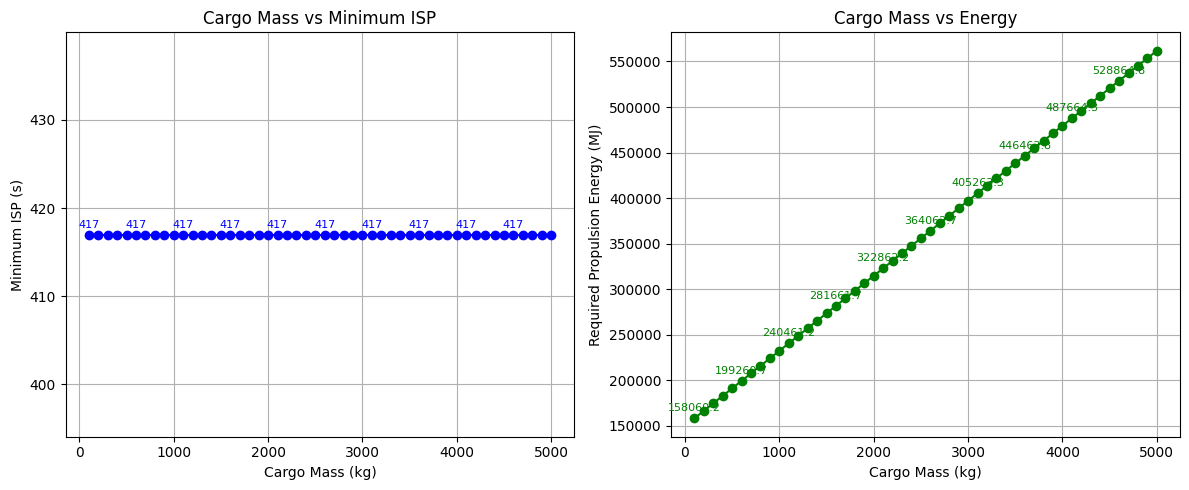

In [ ]:
import math
import matplotlib.pyplot as plt

# 定数
g0 = 9.81  # m/s²
delta_v = 9400  # m/s
extra_component_mass = 2000  # Avionicsなど

# Cargoの範囲
cargo_range = list(range(100, 5001, 100))  # 100kg～5000kgを100kg刻み

# ターゲット燃料質量比（%）
target_fuel_fraction = (80, 90)

# ISP探索関数
def find_min_isp(cargo_mass, delta_v=delta_v):
    isp = 50  # 初期値（仮）
    max_isp = 5000
    tolerance = 0.01

    while isp < max_isp:
        ve = isp * g0
        # 想定乾燥重量（cargo + subsystem）
        subsystem_mass = 0.1 * cargo_mass + extra_component_mass
        dry_mass = cargo_mass + subsystem_mass

        # ロケット方程式による質量比
        mass_ratio = math.exp(delta_v / ve)
        wet_mass = dry_mass * mass_ratio
        fuel_mass = wet_mass - dry_mass
        fuel_fraction = fuel_mass / wet_mass * 100

        # 目標の燃料質量比に収まっていればOK
        if target_fuel_fraction[0] <= fuel_fraction <= target_fuel_fraction[1]:
            return isp, fuel_mass, ve

        isp += 1  # 解像度1秒ずつ

    return None, None, None  # 不可能だった場合

# 計算実行
isp_list = []
energy_list = []

for cargo in cargo_range:
    isp, fuel_mass, ve = find_min_isp(cargo)
    if isp is not None:
        isp_list.append(isp)
        # エネルギー (MJ)
        energy = 0.5 * fuel_mass * ve**2 / 1e6
        energy_list.append(energy)
    else:
        isp_list.append(None)
        energy_list.append(None)

# === グラフ描画 ===
plt.figure(figsize=(12, 5))

# --- ISP vs Cargo ---
plt.subplot(1, 2, 1)
plt.plot(cargo_range, isp_list, 'bo-', label="Min Required ISP")
plt.xlabel("Cargo Mass (kg)")
plt.ylabel("Minimum ISP (s)")
plt.title("Cargo Mass vs Minimum ISP")
plt.grid(True)

# 5個に1つだけラベル
for i, (x, y) in enumerate(zip(cargo_range, isp_list)):
    if y is not None and i % 5 == 0:
        plt.annotate(f"{y:.0f}", xy=(x, y), xytext=(0, 5),
                     textcoords='offset points', ha='center',
                     fontsize=8, color='blue')

# --- Energy vs Cargo ---
plt.subplot(1, 2, 2)
plt.plot(cargo_range, energy_list, 'go-', label="Required Energy (MJ)")
plt.xlabel("Cargo Mass (kg)")
plt.ylabel("Required Propulsion Energy (MJ)")
plt.title("Cargo Mass vs Energy")
plt.grid(True)

for i, (x, y) in enumerate(zip(cargo_range, energy_list)):
    if y is not None and i % 5 == 0:
        plt.annotate(f"{y:.1f}", xy=(x, y), xytext=(0, 5),
                     textcoords='offset points', ha='center',
                     fontsize=8, color='green')

plt.tight_layout()
plt.show()


In [ ]:
import math

# Constants
g0 = 9.81  # m/s²
delta_v_total = 9400  # m/s
extra_component_mass = 2000  # avionics, battery, structure, etc.

fuel_combo = [
    {"fuel": "RP-1/LOX", "isp": 330, "tank_ratio": 0.08},
    {"fuel": "LH2/LOX", "isp": 440, "tank_ratio": 0.15},
    {"fuel": "Methane/LOX", "isp": 370, "tank_ratio": 0.10},
    {"fuel": "Hybrid RP1 + LH2", "isp": 400, "tank_ratio": 0.12},
]

cargo_list = [0, 500, 1000, 2000]

# Dry/wet ratios to test (in %, realistic range)
target_dry_wet_ratios = [10, 12.5, 15]  # dry_mass / wet_mass

def fuel_calc_dry_wet_method(cargo, isp, tank_ratio, target_drywet_percent):
    dry_subsystem = cargo + extra_component_mass
    dry_mass_total = dry_subsystem / (1 - tank_ratio)  # includes tanks

    dry_wet_ratio = target_drywet_percent / 100
    wet_mass = dry_mass_total / dry_wet_ratio
    fuel_mass = wet_mass - dry_mass_total

    ve = isp * g0
    try:
        achievable_dv = ve * math.log(wet_mass / dry_mass_total)
    except (ValueError, ZeroDivisionError):
        return None

    return {
        "dry_mass": dry_mass_total,
        "wet_mass": wet_mass,
        "fuel_mass": fuel_mass,
        "dry_wet_ratio": dry_wet_ratio * 100,
        "achievable_dv": achievable_dv
    }

# Run
for cargo in cargo_list:
    print(f"\n=== Cargo: {cargo} kg ===")
    for fuel in fuel_combo:
        print(f"  Fuel: {fuel['fuel']}")
        for ratio in target_dry_wet_ratios:
            result = fuel_calc_dry_wet_method(cargo, fuel["isp"], fuel["tank_ratio"], ratio)
            if not result:
                print(f"    ⚠ Calculation failed for Dry/Wet = {ratio}%")
                continue

            delta_v_ok = result["achievable_dv"] >= delta_v_total
            print(f"    Dry/Wet: {ratio:.1f}% → Δv = {result['achievable_dv']:.1f} m/s {'✓' if delta_v_ok else '✗'}")
            if delta_v_ok:
                print(f"      Fuel Mass: {result['fuel_mass']:.1f} kg")
                print(f"      Dry Mass: {result['dry_mass']:.1f} kg")
                print(f"      Wet Mass: {result['wet_mass']:.1f} kg")
                # break  # 最小のdry/wetで成功したら打ち切り



=== Cargo: 0 kg ===
  Fuel: RP-1/LOX
    Dry/Wet: 10.0% → Δv = 7454.2 m/s ✗
    Dry/Wet: 12.5% → Δv = 6731.8 m/s ✗
    Dry/Wet: 15.0% → Δv = 6141.5 m/s ✗
  Fuel: LH2/LOX
    Dry/Wet: 10.0% → Δv = 9938.9 m/s ✓
      Fuel Mass: 21176.5 kg
      Dry Mass: 2352.9 kg
      Wet Mass: 23529.4 kg
    Dry/Wet: 12.5% → Δv = 8975.7 m/s ✗
    Dry/Wet: 15.0% → Δv = 8188.7 m/s ✗
  Fuel: Methane/LOX
    Dry/Wet: 10.0% → Δv = 8357.7 m/s ✗
    Dry/Wet: 12.5% → Δv = 7547.7 m/s ✗
    Dry/Wet: 15.0% → Δv = 6886.0 m/s ✗
  Fuel: Hybrid RP1 + LH2
    Dry/Wet: 10.0% → Δv = 9035.3 m/s ✗
    Dry/Wet: 12.5% → Δv = 8159.7 m/s ✗
    Dry/Wet: 15.0% → Δv = 7444.3 m/s ✗

=== Cargo: 500 kg ===
  Fuel: RP-1/LOX
    Dry/Wet: 10.0% → Δv = 7454.2 m/s ✗
    Dry/Wet: 12.5% → Δv = 6731.8 m/s ✗
    Dry/Wet: 15.0% → Δv = 6141.5 m/s ✗
  Fuel: LH2/LOX
    Dry/Wet: 10.0% → Δv = 9938.9 m/s ✓
      Fuel Mass: 26470.6 kg
      Dry Mass: 2941.2 kg
      Wet Mass: 29411.8 kg
    Dry/Wet: 12.5% → Δv = 8975.7 m/s ✗
    Dry/Wet: 15.0% →

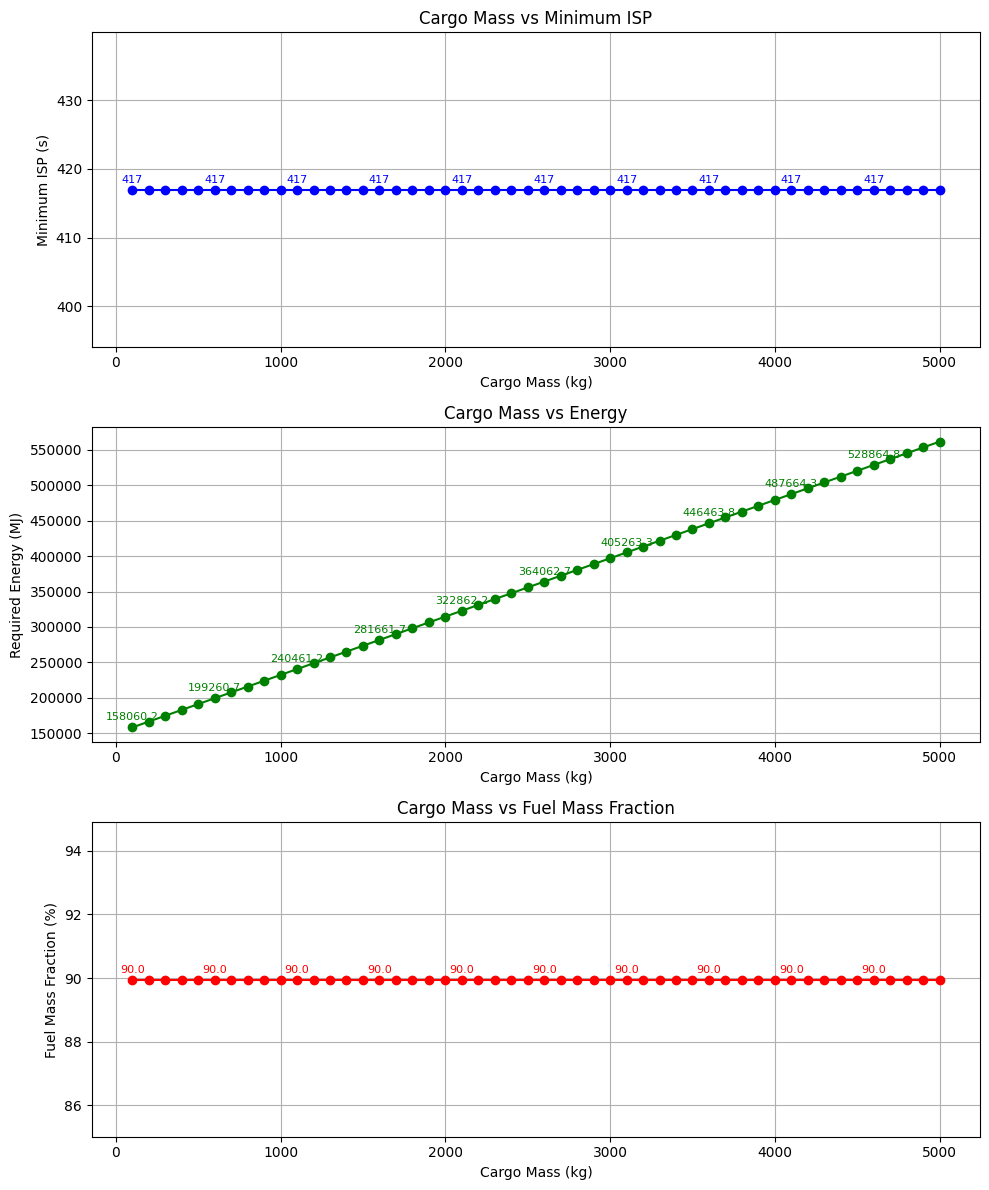


=== Data Table ===
 Cargo Mass (kg)  Min ISP (s)  Fuel Mass Fraction (%)  Required Energy (MJ)
             100          417               89.952596         158060.163210
             200          417               89.952596         166300.266505
             300          417               89.952596         174540.369800
             400          417               89.952596         182780.473096
             500          417               89.952596         191020.576391
             600          417               89.952596         199260.679686
             700          417               89.952596         207500.782981
             800          417               89.952596         215740.886277
             900          417               89.952596         223980.989572
            1000          417               89.952596         232221.092867
            1100          417               89.952596         240461.196163
            1200          417               89.952596         248701

In [ ]:
import math
import matplotlib.pyplot as plt
import pandas as pd

# 定数
g0 = 9.81  # m/s²
delta_v = 9400  # m/s
extra_component_mass = 2000  # Avionicsなど

# Cargoの範囲
cargo_range = list(range(100, 5001, 100))  # 100kg～5000kgを100kg刻み

# ターゲット燃料質量比（%）
target_fuel_fraction = (80, 90)

# ISP探索関数
def find_min_isp(cargo_mass, delta_v=delta_v):
    isp = 50  # 初期値
    max_isp = 5000

    while isp < max_isp:
        ve = isp * g0
        subsystem_mass = 0.1 * cargo_mass + extra_component_mass
        dry_mass = cargo_mass + subsystem_mass

        mass_ratio = math.exp(delta_v / ve)
        wet_mass = dry_mass * mass_ratio
        fuel_mass = wet_mass - dry_mass
        fuel_fraction = fuel_mass / wet_mass * 100

        if target_fuel_fraction[0] <= fuel_fraction <= target_fuel_fraction[1]:
            return isp, fuel_mass, ve, fuel_fraction

        isp += 1

    return None, None, None, None

# データ計算
isp_list = []
energy_list = []
fuel_fraction_list = []

for cargo in cargo_range:
    isp, fuel_mass, ve, fuel_frac = find_min_isp(cargo)
    if isp is not None:
        isp_list.append(isp)
        energy_list.append(0.5 * fuel_mass * ve**2 / 1e6)  # MJ
        fuel_fraction_list.append(fuel_frac)
    else:
        isp_list.append(None)
        energy_list.append(None)
        fuel_fraction_list.append(None)

# DataFrame作成
df = pd.DataFrame({
    "Cargo Mass (kg)": cargo_range,
    "Min ISP (s)": isp_list,
    "Fuel Mass Fraction (%)": fuel_fraction_list,
    "Required Energy (MJ)": energy_list
})

# === グラフ描画 ===
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# --- ISP vs Cargo ---
axes[0].plot(cargo_range, isp_list, 'bo-', label="Min Required ISP")
axes[0].set_xlabel("Cargo Mass (kg)")
axes[0].set_ylabel("Minimum ISP (s)")
axes[0].set_title("Cargo Mass vs Minimum ISP")
axes[0].grid(True)
for i, (x, y) in enumerate(zip(cargo_range, isp_list)):
    if y is not None and i % 5 == 0:
        axes[0].annotate(f"{y:.0f}", xy=(x, y), xytext=(0, 5),
                         textcoords='offset points', ha='center',
                         fontsize=8, color='blue')

# --- Energy vs Cargo ---
axes[1].plot(cargo_range, energy_list, 'go-', label="Required Energy (MJ)")
axes[1].set_xlabel("Cargo Mass (kg)")
axes[1].set_ylabel("Required Energy (MJ)")
axes[1].set_title("Cargo Mass vs Energy")
axes[1].grid(True)
for i, (x, y) in enumerate(zip(cargo_range, energy_list)):
    if y is not None and i % 5 == 0:
        axes[1].annotate(f"{y:.1f}", xy=(x, y), xytext=(0, 5),
                         textcoords='offset points', ha='center',
                         fontsize=8, color='green')

# --- Fuel Mass Fraction vs Cargo ---
axes[2].plot(cargo_range, fuel_fraction_list, 'ro-', label="Fuel Mass Fraction")
axes[2].set_xlabel("Cargo Mass (kg)")
axes[2].set_ylabel("Fuel Mass Fraction (%)")
axes[2].set_title("Cargo Mass vs Fuel Mass Fraction")
axes[2].grid(True)
for i, (x, y) in enumerate(zip(cargo_range, fuel_fraction_list)):
    if y is not None and i % 5 == 0:
        axes[2].annotate(f"{y:.1f}", xy=(x, y), xytext=(0, 5),
                         textcoords='offset points', ha='center',
                         fontsize=8, color='red')

plt.tight_layout()
plt.show()

# === テーブル表示 ===
print("\n=== Data Table ===")
print(df.to_string(index=False))
